In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.distributions.log_normal import LogNormal
from scipy.special import erfinv
from Helper.ImportDatasets import df_epsilon, df_epsilon_crit
from Method.calculate_distribution_a import distribution_a, calculate_mu_upper, integrand, log_normal_cdf, common_constant

# Introduction
In this notebook we look at how to sample mu and s, either by first sampling the mode, or by first sampling the median

# Mu and s given Mode of log normal

In [70]:
# mode of log normal is given by exp(mu - s^2), we also are given an a, we thus have
def calculate_mu_and_s_from_mode(a, mode, sigma):
    
    
    # catch error, if there is an a that is larger or equal to mode, then we can't find a solution
    if torch.any(a >= mode):
        raise ValueError('a is larger or equal to mode')
    
    # Also catch error, if mode is larger than the upper bound of the mode, then we can't find a solution
    if torch.any(mode >= upper_bound_mode(a, sigma)):
        raise ValueError('mode is larger or equal to upper bound')
    
    K = common_constant(sigma)
    C1 = torch.log(mode)*2*K**2 + torch.log(a)**2
    C2 = 2*K**2+2*torch.log(a)
    mu1 = (C2 + torch.sqrt(C2**2 - 4*C1))/2
    # We discard mu2 as it gives veary peaked distributions
    #mu2 = (C2 - torch.sqrt(C2**2 - 4*C1))/2
    s1 = torch.sqrt(mu1 - torch.log(mode))
    # Some rounding errors occur making mu2 - torch.log(mode) a tiny bit negative, we thus set it to the absolute value
    #ind = torch.where(mu2 - torch.log(mode) < 0)
    #s2 = torch.sqrt(torch.abs(mu2 - torch.log(mode)))
    return torch.stack([mu1,s1])

# The upper bound is given by the fact that C2**2 - 4*C1 > 0. The lower bound is given by the fact that mu > log(a) which works out to be mode > a.
def upper_bound_mode(a, sigma):
    K = common_constant(sigma)
    return a * torch.exp((K**2)/2)

Text(0, 0.5, 'mode')

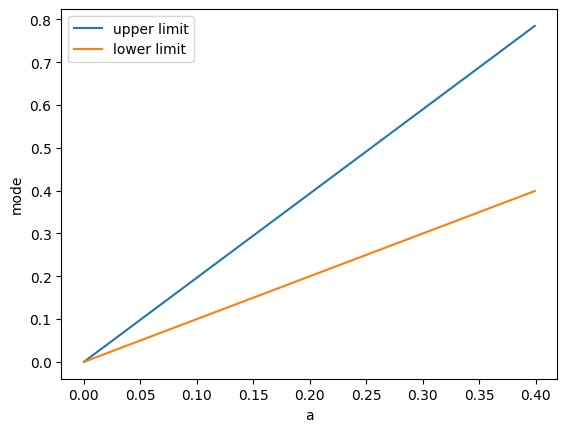

In [71]:
# We check the upper and lower bound of the mode
sigma = torch.tensor([0.05])
a = torch.arange(0,0.4,0.001)
upper_limit = upper_bound_mode(a, sigma)

plt.plot(a,upper_limit, label = 'upper limit')
plt.plot(a,a, label = 'lower limit')
plt.legend()
plt.xlabel('a')
plt.ylabel('mode')

In [72]:
a = torch.arange(0,0.4,0.001)+0.001
upper_limit = upper_bound_mode(a, sigma)
modes = torch.rand(1000, *a.shape) * (upper_limit - a) + a

In [74]:
params = calculate_mu_and_s_from_mode(a, modes, sigma)

In [75]:
ans1 = log_normal_cdf(a, *params)

# Mu and s given Median of log normal

In [13]:
def calculate_mu_and_s_from_median(a, median, sigma):
    """
    Calculate mu and s from median and a.
    
    Median of log normal is given by exp(mu), we also are given an a, this gives us two equations.
    """
    # catch error, if there is an a that is larger or equal to median, then we can't find a solution
    if torch.any(a >= median):
        raise ValueError('a is larger or equal to median')
  
    
    K = common_constant(sigma)
    mu = torch.log(median)
    s = (torch.log(a) - mu)/(K * np.sqrt(2))
    return torch.stack([mu,s])

# Median has no upper bound as far as I know, but we can bound it by our expectations. e.g. no larger than 0.4.

In [68]:
# test it out
sigma = torch.tensor([0.05])
a = torch.arange(0,0.4,0.001)+0.001
upper_limit = 0.4
medians = torch.rand(1000, *a.shape) * (upper_limit - a) + a+0.001

In [69]:
params = calculate_mu_and_s_from_median(a, medians, sigma)
ans1 = log_normal_cdf(a, *params)

# Main function

Lets make it work!

In [5]:
import matplotlib.animation as animation
import random
"""
We pick sigma, delta, network and number of samples. Although delta doesn't matter much as the region of a we use is large enough to quickly find a solution where prob = 1
"""
def run(network, ani = False, shuffle = False, step_size_a = 0.001, sigma = 0.05, n_samples = 1000):
    delta = 0.05
    
    # Get the network and test set, then split the images
    df_for_network = df_epsilon[df_epsilon['network'] == network]
    df_for_network = df_for_network[df_for_network['ds'] == 'test']
    df_per_image = [df_for_network[df_for_network['image'] == i] for i in df_for_network['image'].unique()]
    
    # We find the distribution of 'a' for the following bins
    a = torch.arange(step_size_a,0.4,step_size_a)
    
    # We keep track of the distributions of 'a' and its max probability
    distributions_of_a = []
    
    # Initialize D (dataset) and the default value to put in if we don't find elligible epsilons
    D = torch.tensor([[],[]],dtype=torch.float32)
    default = torch.tensor([[0],[0.4]],dtype=torch.float32)
    
    if shuffle:
        random.shuffle(df_per_image)
    
    for i,image in enumerate(df_per_image):
        # We put in the default value first and then change it to the lower and upper bound of the image
        D = torch.cat((D,default),dim=1)
        
        # unsat means epsilon >, thus lower bound
        lower_bound = np.max(image[image['result']=='unsat']['epsilon'].values)
        # sat means epsilon <, thus upper bound
        upper_bound = np.min(image[image['result']=='sat']['epsilon'].values)
        D[0,-1] = lower_bound
        D[1,-1] = upper_bound
        
        print(f"image {i+1}")
        
        # Sample in our bins of 'a', 100 samples are taken per bin
        a_samples = torch.rand(100,*a.shape)*step_size_a+a
        # We calculate the distribution of each sample
        distr = distribution_a(a_samples,D,sigma,n_samples)
        max_distr = torch.max(distr)
        distributions_of_a.append(distr)
        
        # We check if we have attained a probability of at least 1-delta
        if max_distr > 1-delta:
            print('found')
            break
        
        # Most likely the above will not happen but the distribution of 'a' will become too peaked to fit in the range of a that has been given
        # In that case we are also satisfied as we know 'a' is in a small enough region
        if torch.isnan(max_distr):
           distributions_of_a.pop()
           print('found: region is too small')
           break
    
    if ani:
        fig, ax = plt.subplots()
    
        ax.set_ylim(0, 1)
        line, = ax.plot(a, np.tile(0,len(a)))
        
        
        def animate(i):
            line.set_ydata(distributions_of_a[i])  # update the data.
            return line,
        
        
        ani = animation.FuncAnimation(
            fig, animate, frames=len(distributions_of_a), interval=20, blit=True, save_count=50)
        
        # To save the animation, use e.g.
        #
        ani.save(network+".gif")
    
    return distributions_of_a

# Test parts of the function

In [4]:
# variables
network = 'mnist-net'
step_size_a = 0.001
sigma = 0.05
n_samples = 1000

In [5]:
#Gather Data
df_for_network = df_epsilon[df_epsilon['network'] == network]
df_for_network = df_for_network[df_for_network['ds'] == 'test']
df_per_image = [df_for_network[df_for_network['image'] == i] for i in df_for_network['image'].unique()]

In [9]:
image = df_per_image[0]

# unsat means epsilon >, thus lower bound
lower_bound = np.max(image[image['result']=='unsat']['epsilon'].values)
# sat means epsilon <, thus upper bound
upper_bound = np.min(image[image['result']=='sat']['epsilon'].values)

a = torch.arange(step_size_a,0.4,step_size_a)

In [10]:
D = torch.tensor([[lower_bound],[upper_bound]])
# Sample in our bins of 'a'
a_samples = torch.rand(100,*a.shape)*step_size_a+a

In [19]:
sigma = torch.tensor([sigma])

# Bounds of the medians
lower_bound_median = a_samples + 0.00001 # We add a small value to a as median > a
#mu_upper = torch.exp(calculate_mu_upper(a_samples, sigma))
upper_bound_median = 0.4
medians = torch.rand(n_samples, *a_samples.shape) * (upper_bound_median - lower_bound_median) + lower_bound_median
thetas = calculate_mu_and_s_from_median(a_samples, medians, sigma)

In [30]:
tries = log_normal_cdf(D[1], thetas[0], thetas[1]) - log_normal_cdf(D[0], thetas[0], thetas[1])
tries.shape

torch.Size([1000, 100, 399])

In [31]:
distr = torch.mean(tries, dim=[0,1])

(0.0, 0.02)

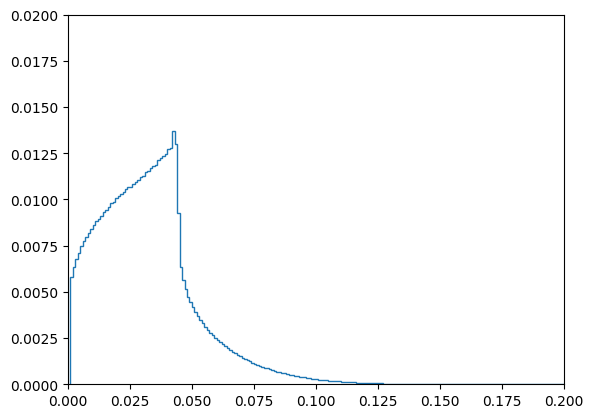

In [47]:
plt.stairs(distr, torch.cat((a,torch.tensor([0.4]))))
plt.xlim(0,0.2)
plt.ylim(0,0.02)

# Test the function

NameError: name 'distributions_of_a' is not defined

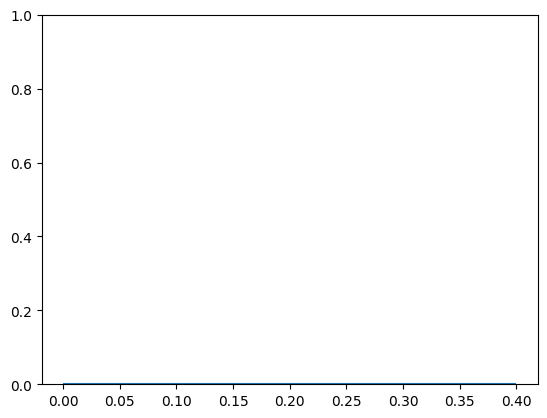

In [49]:
# Save as animation
import matplotlib.animation as animation

fig, ax = plt.subplots()

ax.set_ylim(0, 1)
line, = ax.plot(a, np.tile(0,len(a)))


def animate(i):
    line.set_ydata(distributions_of_a[i])  # update the data.
    return line,


ani = animation.FuncAnimation(
    fig, animate, frames=len(distributions_of_a), interval=20, blit=True, save_count=50)

# To save the animation, use e.g.
#
ani.save(network+".gif")

In [6]:
network = df_epsilon['network'].unique()[0]
distr = run(network)

image 1


NameError: name 'a_samples' is not defined